# (10) Nardin play

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## From MATLAB to h5py (Nardin)

In [2]:
from utils.process import mat2h5py

base_dir = '/home/hadi/Documents/MTMST'
xtract_dir = pjoin(base_dir, 'Nardin', 'MTproject_data', 'xtracted')
save_dir = pjoin(base_dir, 'MTLFP-MST', 'xtracted_python')
os.makedirs(save_dir, exist_ok=True)

In [3]:
mat2h5py(
    load_dir=xtract_dir,
    save_dir=save_dir,
    file_name='NARDIN',
    tres=25,
    grd=15,
)

group ytu304 created: 100%|██████████| 23/23 [00:57<00:00,  2.52s/it]


DONE.

## Load an expt

In [2]:
base_dir = '/home/hadi/Documents/MTMST'
load_dir = pjoin(base_dir, 'MTLFP-MST', 'xtracted_python')
file = pjoin(load_dir, 'NARDIN_tres25.h5')
file = h5py.File(file, 'r')

In [7]:
name = 'ytu295'
group = file[name]
list(group)

['badspks',
 'cellindex',
 'field',
 'fixlost',
 'hyperflow',
 'latency',
 'lfp',
 'nx',
 'ny',
 'partition',
 'rf_loc',
 'spatres',
 'spks',
 'stim1',
 'stim2']

In [8]:
partition = np.array(group['partition'], dtype=int)
spks = np.array(group['spks'], dtype=float)
nans = np.isnan(spks)
good_channels = nans.sum(0) == 0
good_spks = ~np.array(group['badspks'], dtype=bool)

In [9]:
good_spks.sum() / len(good_spks)

0.9453819444444445

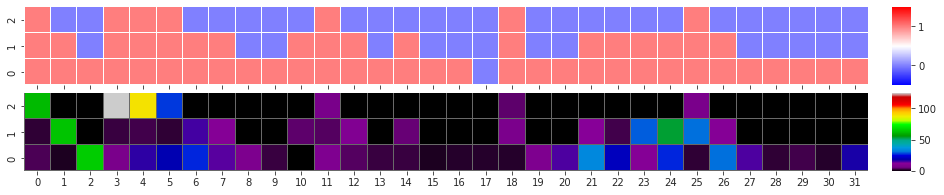

In [10]:
fig, axes = create_figure(2, 1, (13, 2.6), sharex='all', constrained_layout=True)
sns.heatmap(
    good_channels.T,
    cmap='bwr',
    linewidths=0.01,
    vmin=-0.5,
    vmax=1.5, 
    linecolor='w',
    ax=axes[0],
)
sns.heatmap(
    np.nansum(spks, 0).T / len(spks) / 25e-3,
    cmap='nipy_spectral',
    linewidths=0.01,
    linecolor='dimgrey',
    ax=axes[1],
)
for ax in axes.flat:
    ax.invert_yaxis()
plt.show()

## HyperFlow

In [11]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=2,
    radius=7,
)

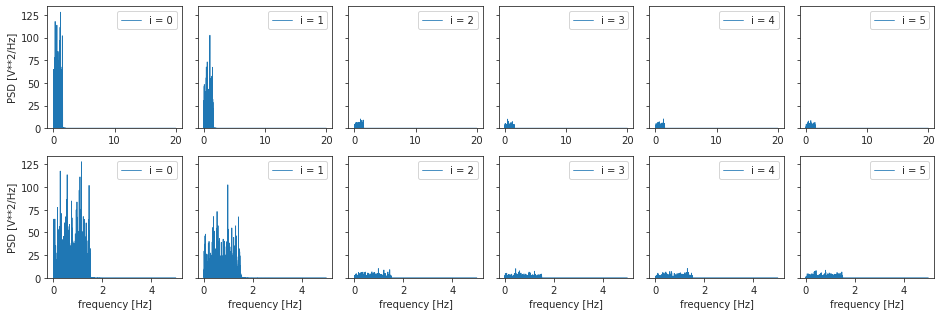

In [12]:
_ = hf.show_psd('opticflow', False, cutoff=5)

In [13]:
stim = hf.compute_hyperflow()
stim.shape

(28800, 16, 16, 2)

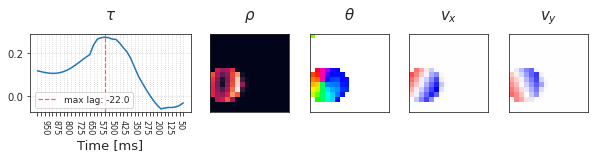

In [14]:
t = 700
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

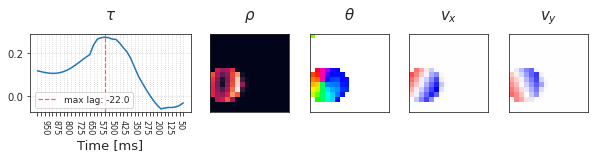

In [15]:
t = 700 + 14400
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

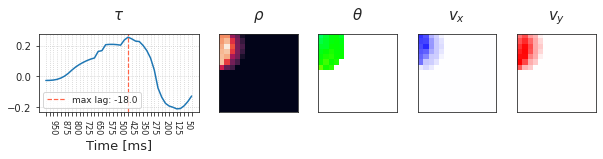

In [16]:
t = 700
vf = VelField(np.array(group['stim1'], dtype=float)[t:t+40])
_ = vf.show(fig_x=10)

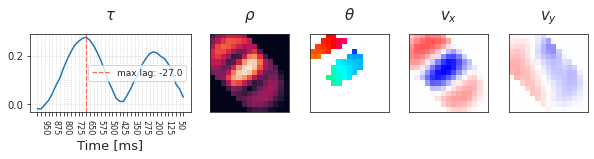

In [33]:
t = 750
vf = VelField(np.array(group['stim1'], dtype=float)[t:t+40])
_ = vf.show(fig_x=10)

## STA

In [34]:
from analysis.sta import compute_sta

lags = 24

### HF generated (1st segment)

In [35]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

In [85]:
bad = list(np.where(np.mean(flatten_arr(sta, 0, 1), 1) == 0)[0])
bad += list(np.where(np.isnan(flatten_arr(sta, 0, 1)).sum(1) != 0)[0])
bad

[10, 17]

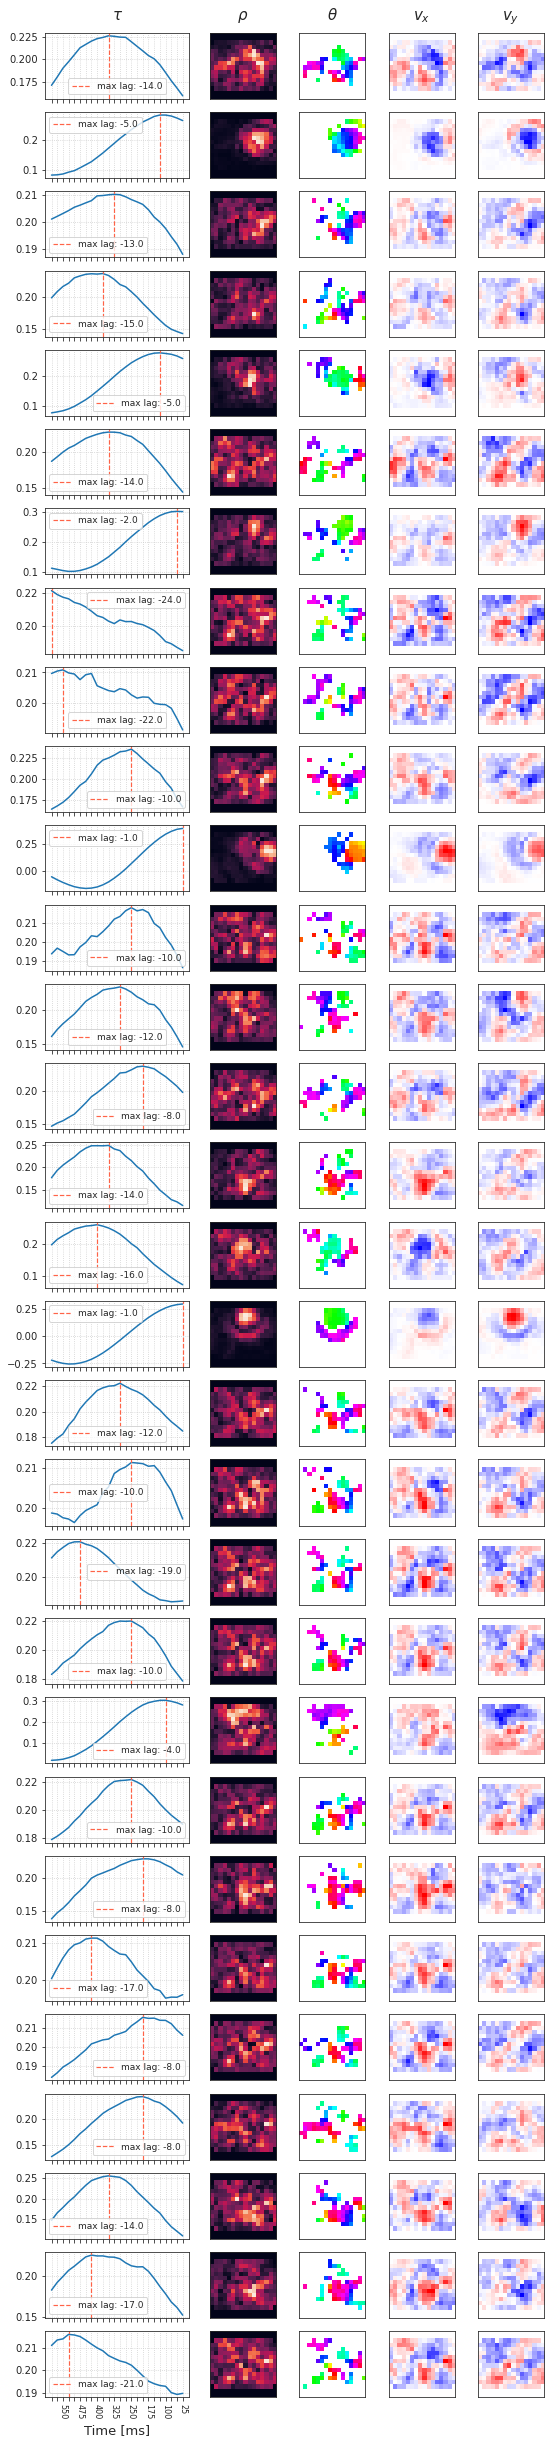

In [90]:
sta = VelField(sta[[i for i in np.where(good_channels[..., 0])[0] if i not in bad]], name=name)
_ = sta.show()

### Original stim (1st segment)

In [91]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=np.array(group['stim1'], dtype=float)[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 15, 15, 2)

In [92]:
bad = list(np.where(np.mean(flatten_arr(sta, 0, 1), 1) == 0)[0])
bad += list(np.where(np.isnan(flatten_arr(sta, 0, 1)).sum(1) != 0)[0])
bad

[10, 17]

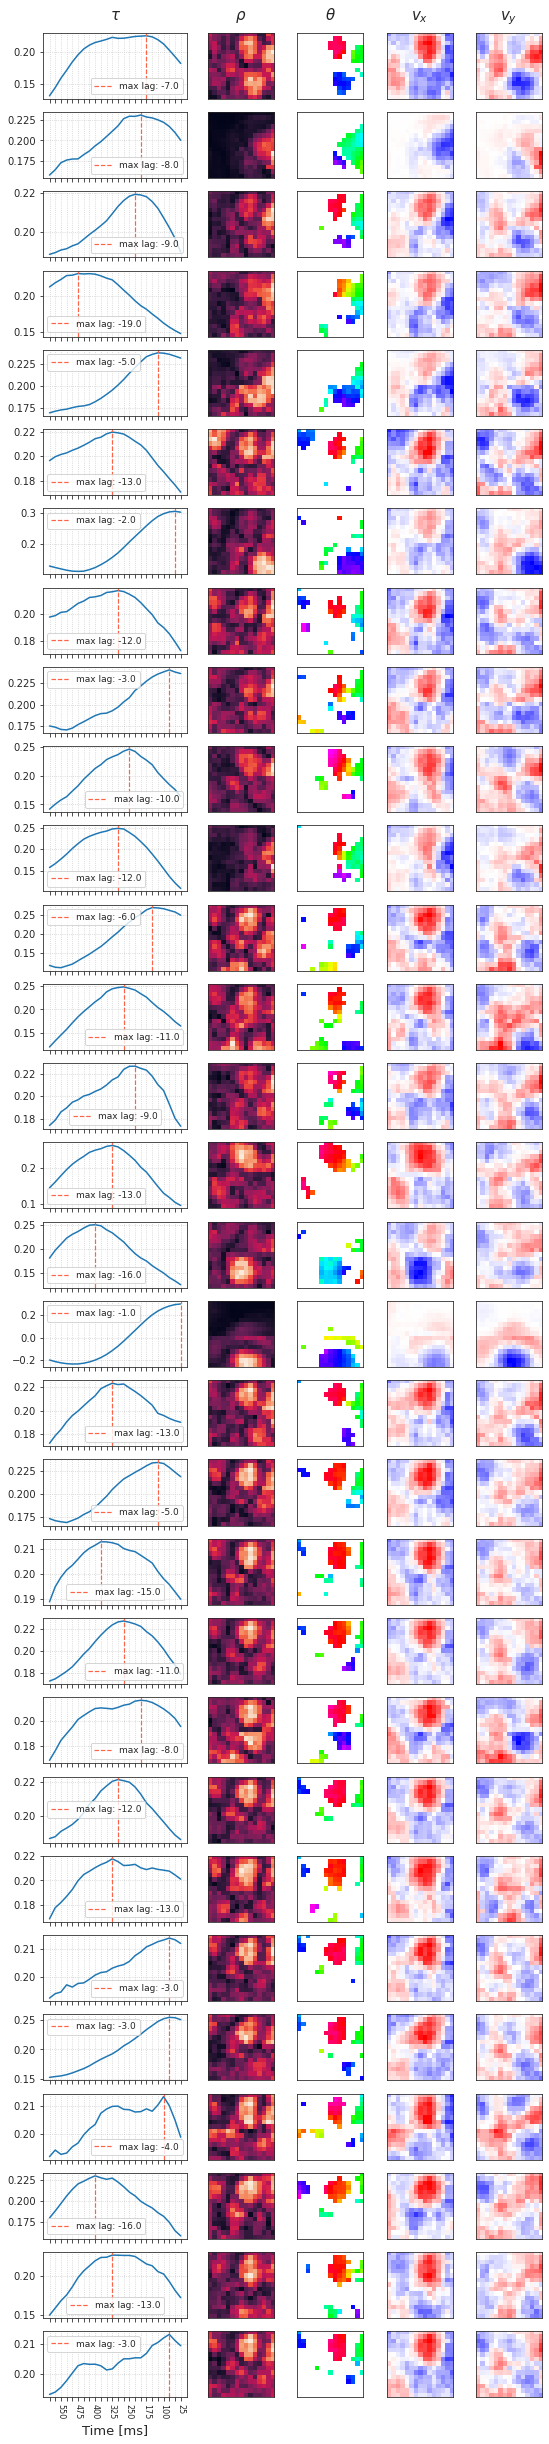

In [93]:
sta = VelField(sta[[i for i in np.where(good_channels[..., 0])[0] if i not in bad]], name=name)
_ = sta.show()

## STA (with fine HF gen stim)

In [94]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=1,
    radius=7,
)
stim = hf.compute_hyperflow()

In [95]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
    verbose=True,
)
sta.shape

100%|██████████| 13489/13489 [02:01<00:00, 110.96it/s]


(32, 24, 32, 32, 2)

In [96]:
bad = list(np.where(np.mean(flatten_arr(sta, 0, 1), 1) == 0)[0])
bad += list(np.where(np.isnan(flatten_arr(sta, 0, 1)).sum(1) != 0)[0])
bad

[10, 17]

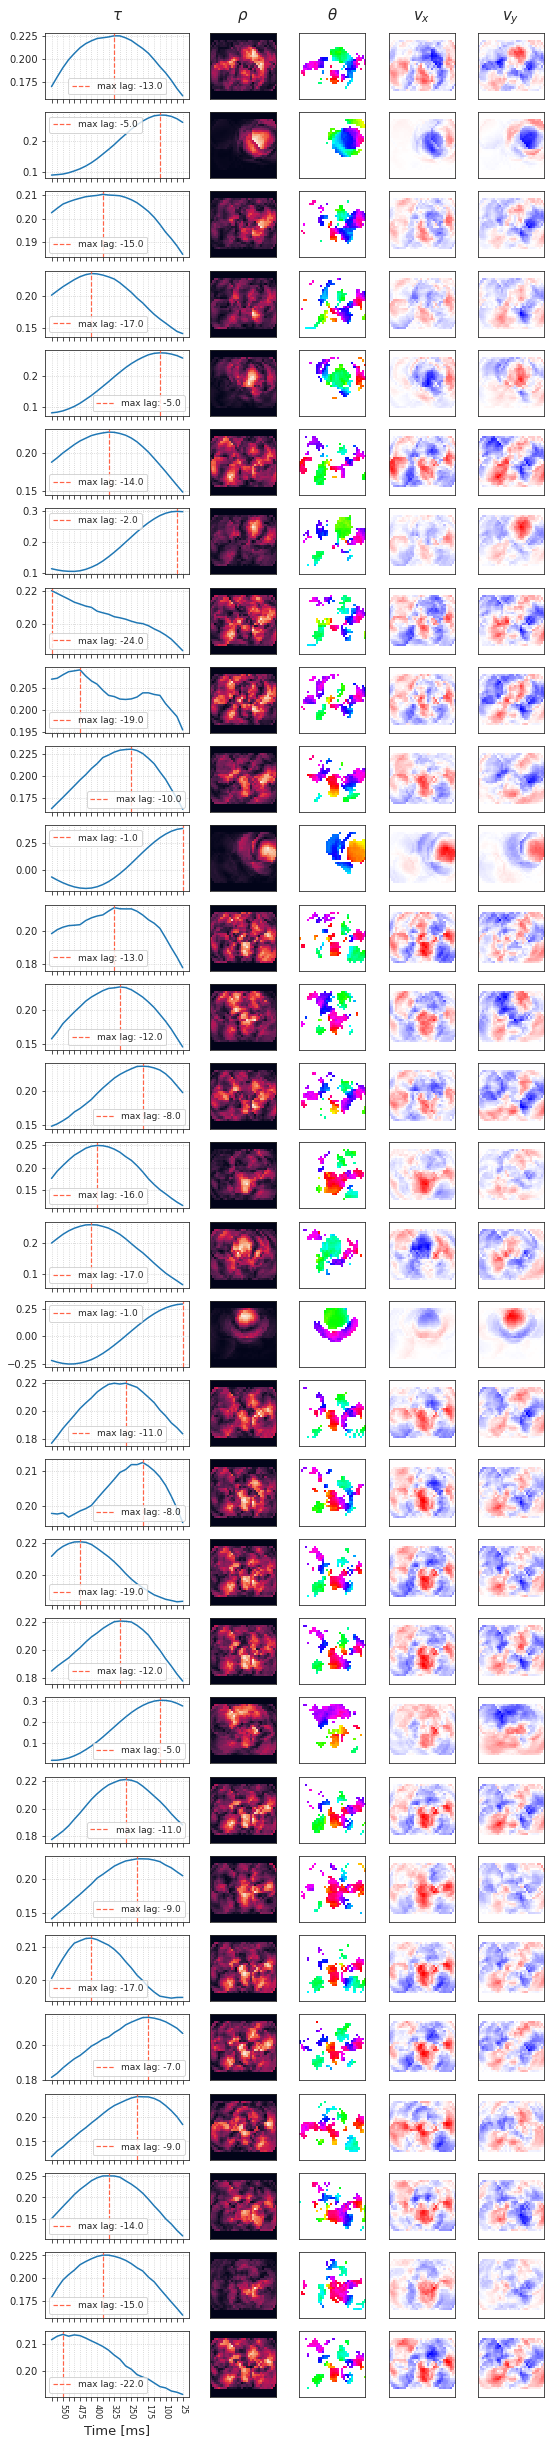

In [97]:
sta = VelField(sta[[i for i in np.where(good_channels[..., 0])[0] if i not in bad]], name=name)
_ = sta.show()

### STA but full field

In [106]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=2,
    radius=np.inf,
)
stim = hf.compute_hyperflow()

In [107]:
seg = range(partition[0], partition[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
    verbose=True,
)
sta.shape

100%|██████████| 13489/13489 [00:23<00:00, 564.23it/s]


(32, 24, 16, 16, 2)

In [108]:
bad = list(np.where(np.mean(flatten_arr(sta, 0, 1), 1) == 0)[0])
bad += list(np.where(np.isnan(flatten_arr(sta, 0, 1)).sum(1) != 0)[0])
bad

[10, 17]

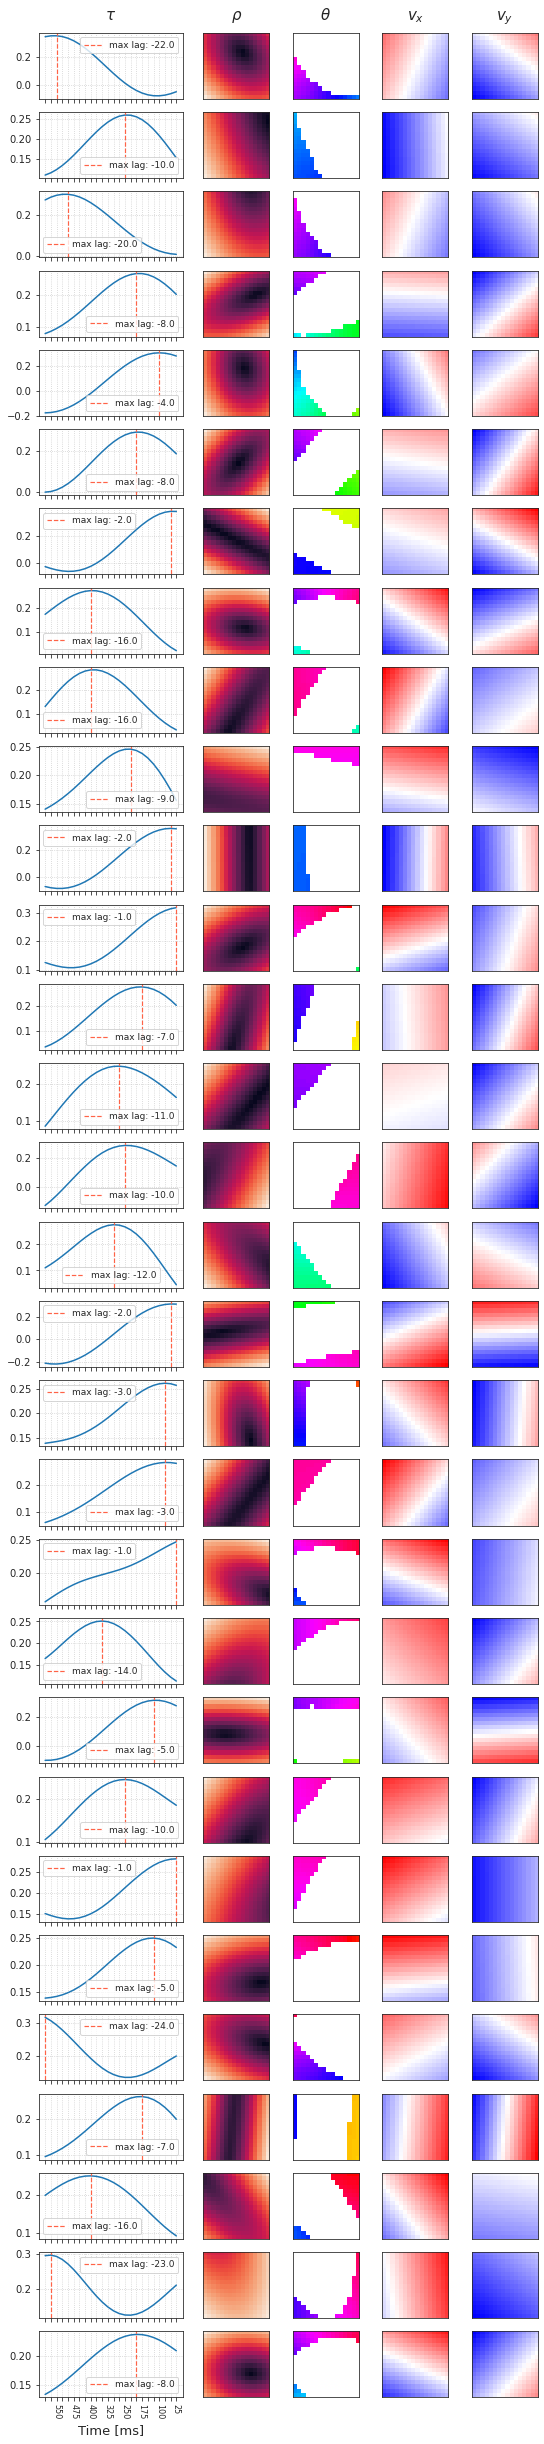

In [109]:
sta = sta[[
    i for i in
    np.where(good_channels[..., 0])[0]
    if i not in bad
]]
sta = VelField(sta, name=name)
_ = sta.show()

## GLM test

In [118]:
from model.dataset import setup_supervised_data
from analysis.glm import GLM

In [110]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=2,
    radius=7,
)
stim = hf.compute_hyperflow()
stim.shape

(28800, 16, 16, 2)

In [117]:
lags = 24
seg = range(partition[0], partition[1])

src, tgt = setup_supervised_data(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
src.shape, tgt.shape

((13489, 24, 16, 16, 2), (13489, 32))

In [129]:
i = 1
glm = GLM(src, tgt[:, i])
_ = glm.fit()

In [130]:
nnll = glm.perf_df()
nnll = nnll.groupby(['alpha']).mean()['nnll']
nnll

alpha
10    0.558713
20    0.487463
50    0.369083
Name: nnll, dtype: float64

expt = ytu295, a = 10.0, nnll = 0.5587134666623892

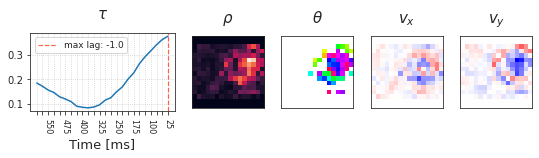

expt = ytu295, a = 20.0, nnll = 0.4874626516418338

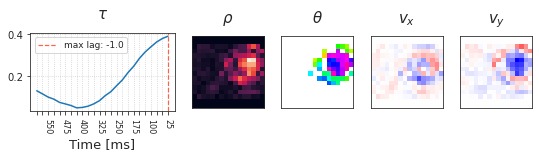

expt = ytu295, a = 50.0, nnll = 0.36908301305251695

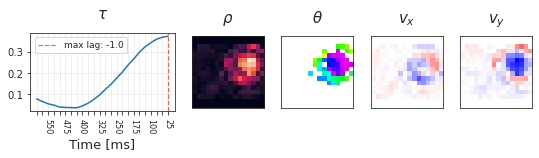

In [131]:
for a, k in glm.kers.items():
    msg = ', '.join([
        f"expt = {name}",
        f"a = {a:0.1f}",
        f"nnll = {nnll[a]}",
    ])

    print(msg)
    k.show()

In [150]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=1,
    radius=7,
)
stim = hf.compute_hyperflow()
stim.shape

(28800, 32, 32, 2)

In [151]:
lags = 24
seg = range(partition[0], partition[1])

src, tgt = setup_supervised_data(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
src.shape, tgt.shape

((13489, 24, 32, 32, 2), (13489, 32))

In [152]:
i = 1
glm = GLM(src, tgt[:, i])
_ = glm.fit()

In [153]:
nnll = glm.perf_df()
nnll = nnll.groupby(['alpha']).mean()['nnll']
nnll

alpha
10    0.648932
20    0.611958
50    0.533450
Name: nnll, dtype: float64

alpha
10    0.558713
20    0.487463
50    0.369083
Name: nnll, dtype: float64

expt = ytu295, a = 10.0, nnll = 0.6489321703266789

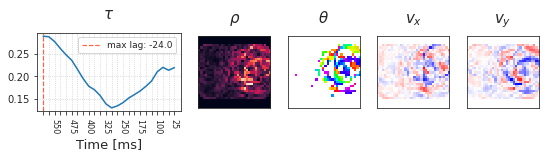

expt = ytu295, a = 20.0, nnll = 0.6119584275169518

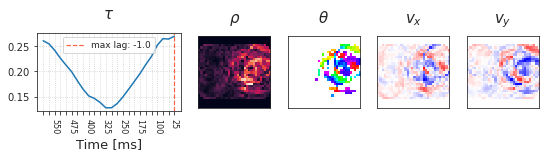

expt = ytu295, a = 50.0, nnll = 0.5334504452803276

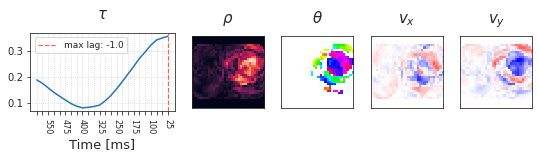

In [154]:
for a, k in glm.kers.items():
    msg = ', '.join([
        f"expt = {name}",
        f"a = {a:0.1f}",
        f"nnll = {nnll[a]}",
    ])

    print(msg)
    k.show()

In [171]:
hf = np.array(group['hyperflow'], dtype=float)
hf = HyperFlow(
    opticflow=hf[:, 2:],
    center=hf[:, :2],
    size=32,
    sres=1,
    radius=7,
)
stim = hf.compute_hyperflow()
stim.shape

(28800, 32, 32, 2)

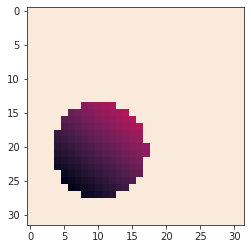

In [172]:
plt.imshow(stim[750, ..., 1])

In [173]:
lags = 24
seg = range(partition[0], partition[1])

src, tgt = setup_supervised_data(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
src.shape, tgt.shape

((13489, 24, 32, 32, 2), (13489, 32))

In [174]:
i = 1
glm = GLM(src, tgt[:, i])
_ = glm.fit()

In [175]:
nnll = glm.perf_df()
nnll = nnll.groupby(['alpha']).mean()['nnll']
nnll

alpha
10    0.648932
20    0.611958
50    0.533450
Name: nnll, dtype: float64

alpha
10    0.648932
20    0.611958
50    0.533450
Name: nnll, dtype: float64

expt = ytu295, a = 10.0, nnll = 0.6489321703266789

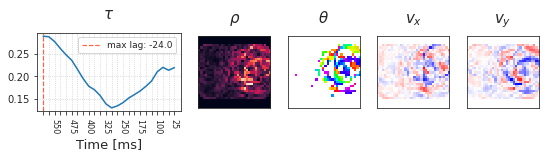

expt = ytu295, a = 20.0, nnll = 0.6119584275169518

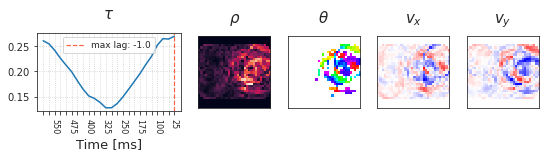

expt = ytu295, a = 50.0, nnll = 0.5334504452803276

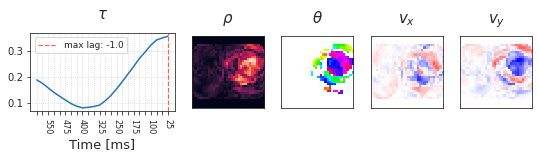

In [176]:
for a, k in glm.kers.items():
    msg = ', '.join([
        f"expt = {name}",
        f"a = {a:0.1f}",
        f"nnll = {nnll[a]}",
    ])

    print(msg)
    k.show()

In [34]:
file.close()

## Load mat file and see
older than above, but same day

In [4]:
path = '/home/hadi/Documents/MTMST/Nardin/MTproject_data/xtracted'
expt = 'tres25_slu020'
load_file = pjoin(path, f'{expt}.mat')

In [5]:
from scipy import io as sio
mat = sio.loadmat(load_file)
len(mat)

37

In [55]:
segments = mat['partition'].ravel().astype(int)
spks = mat['spks'].astype(float)
nans = np.isnan(spks)
good_channels = nans.sum(0) == 0
good_spks = ~mat['badspks'].astype(bool)

In [6]:
good_spks.sum() / len(good_spks)

0.8134953703703703

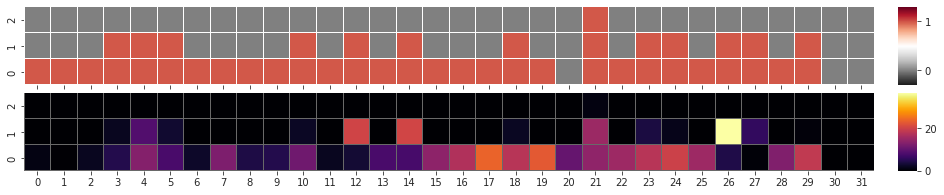

In [8]:
fig, axes = create_figure(2, 1, (13, 2.6), sharex='all', constrained_layout=True)
sns.heatmap(
    good_channels.T,
    cmap='RdGy_r',
    linewidths=0.01,
    vmin=-0.3,
    vmax=1.3, 
    linecolor='w',
    ax=axes[0],
)
sns.heatmap(
    np.nansum(spks, 0).T / len(spks) / 25e-3,
    cmap='inferno',
    linewidths=0.01,
    linecolor='dimgrey',
    ax=axes[1],
)
for ax in axes.flat:
    ax.invert_yaxis()
plt.show()

In [10]:
hf = HyperFlow(
    opticflow=mat['opticflows'].astype(float),
    center=np.concatenate([
        mat['centerx'],
        mat['centery']
    ], axis=1).astype(float),
    size=32,
    sres=2,
    radius=7,
)

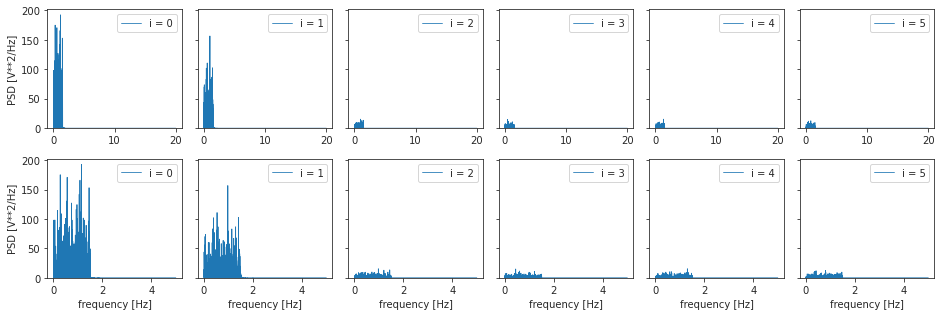

(43200, 16, 16, 2)

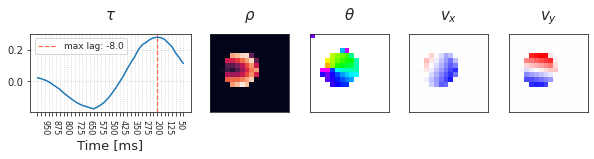

In [13]:
vf = VelField(stim[100:140])
_ = vf.show(fig_x=10)

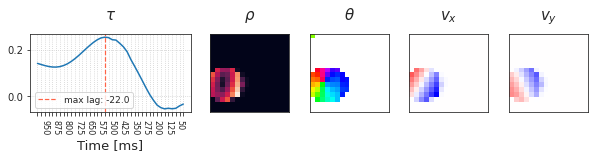

In [14]:
t = 700
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

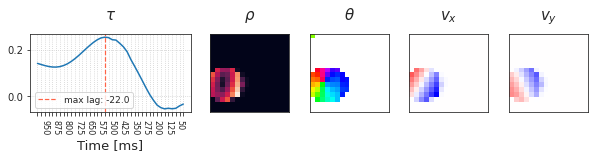

In [15]:
t = 700 + 14400
vf = VelField(stim[t:t+40])
_ = vf.show(fig_x=10)

In [16]:
x = np.concatenate([
    mat['centerx'],
    mat['centery'],
    mat['opticflows'],
], axis=1).astype(float)
x.shape

(43200, 8)

In [17]:
mat['partition'].astype(int).ravel()

array([    0, 14400, 28800, 43200])

In [18]:
t = 1000
x[t], x[t + 14400], x[t + 28800]

(array([  2.22246202,  -4.61538462, -10.26257838,  -3.62221499,
         -1.24476281,  -1.91990594,   0.80632149,  -2.36376592]),
 array([  2.22246202,  -4.61538462, -10.26257838,  -3.62221499,
         -1.24476281,  -1.91990594,   0.80632149,  -2.36376592]),
 array([  2.22246202,  -4.61538462, -10.26257838,  -3.62221499,
         -1.24476281,  -1.91990594,   0.80632149,  -2.36376592]))

In [25]:
lags = 24

In [50]:
stim.shape

(43200, 16, 16, 2)

array([    0, 14400, 28800, 43200], dtype=uint16)

In [26]:
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks)[0],
    stim=stim,
    spks=spks[..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

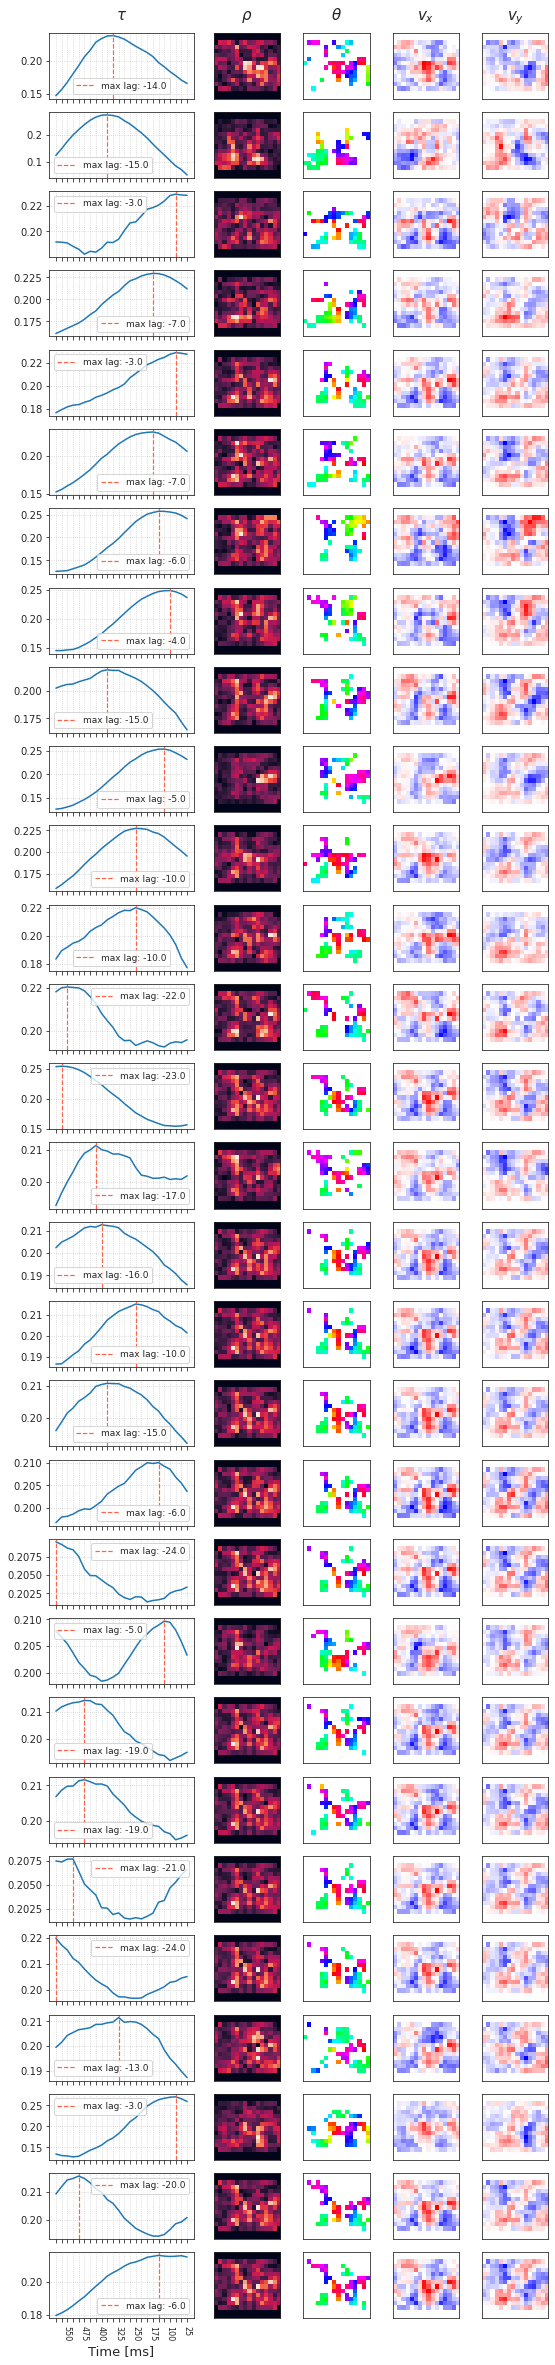

In [49]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [60]:
seg = range(segments[0], segments[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

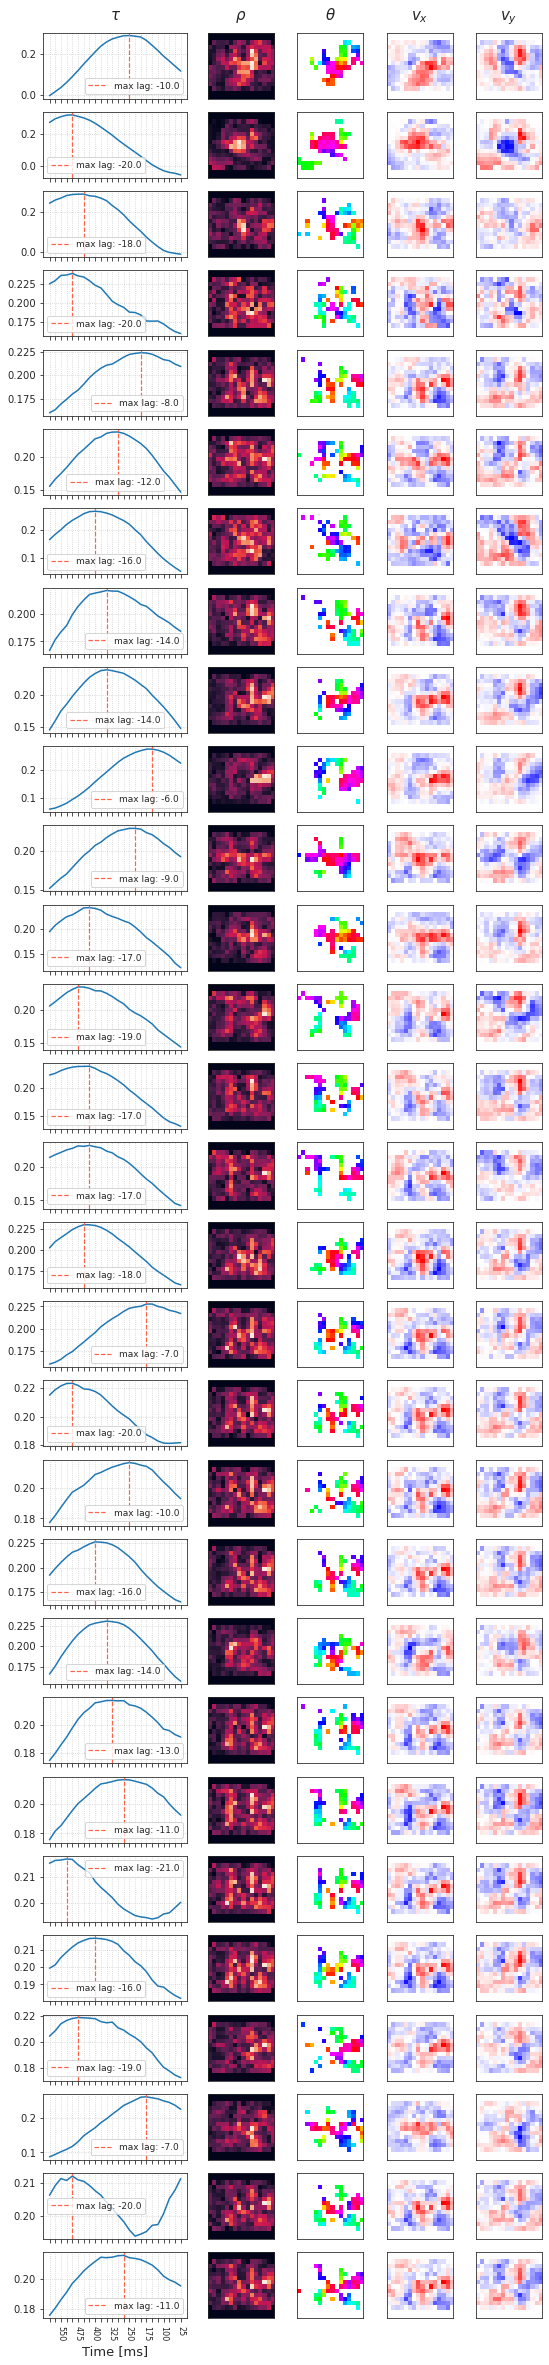

In [61]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [62]:
seg = range(segments[1], segments[2])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

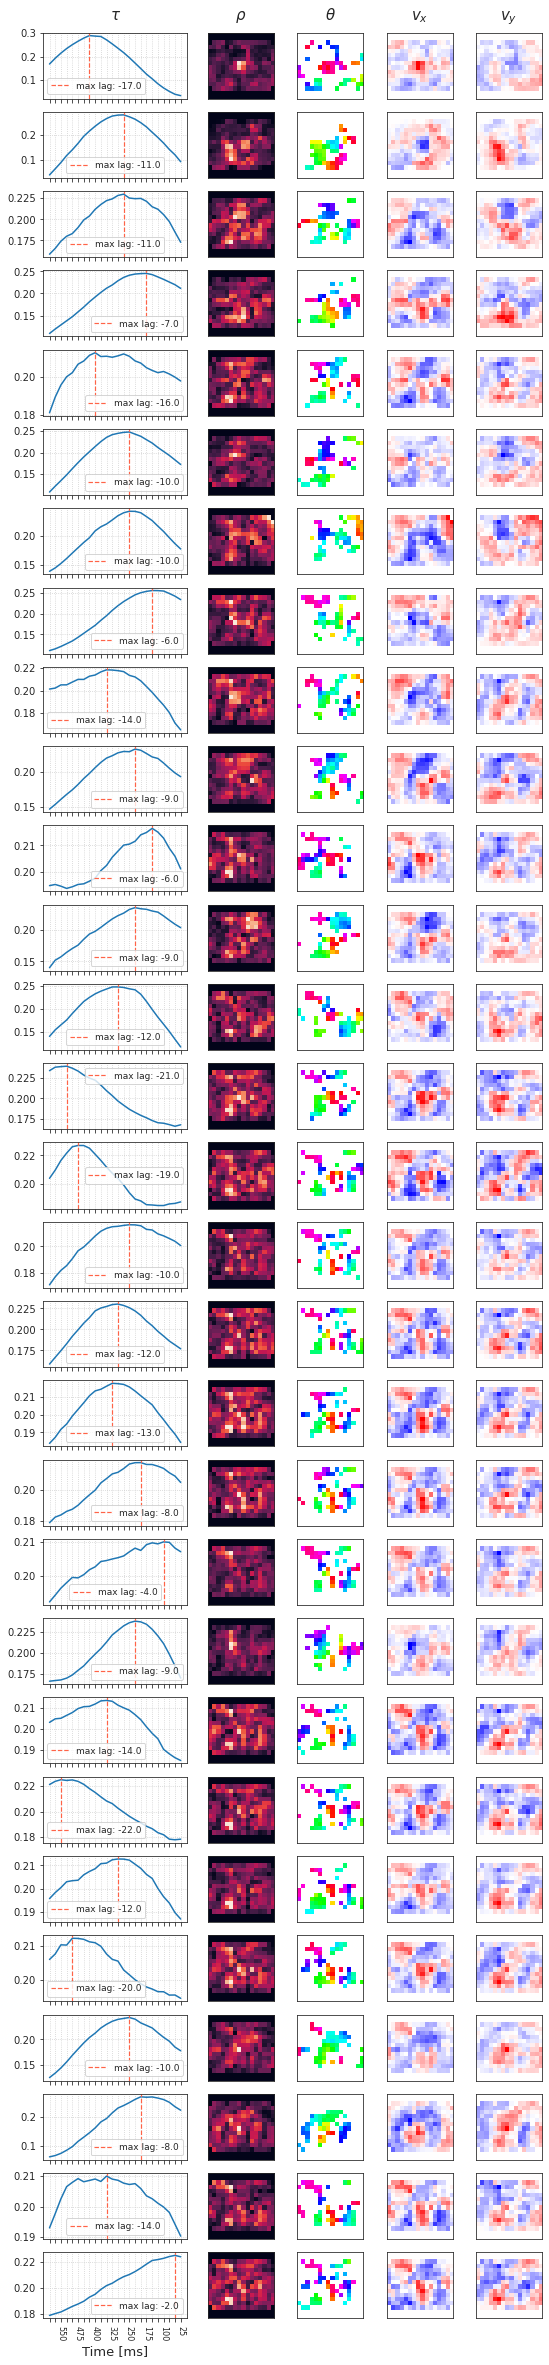

In [63]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [64]:
seg = range(segments[2], segments[3])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

(32, 24, 16, 16, 2)

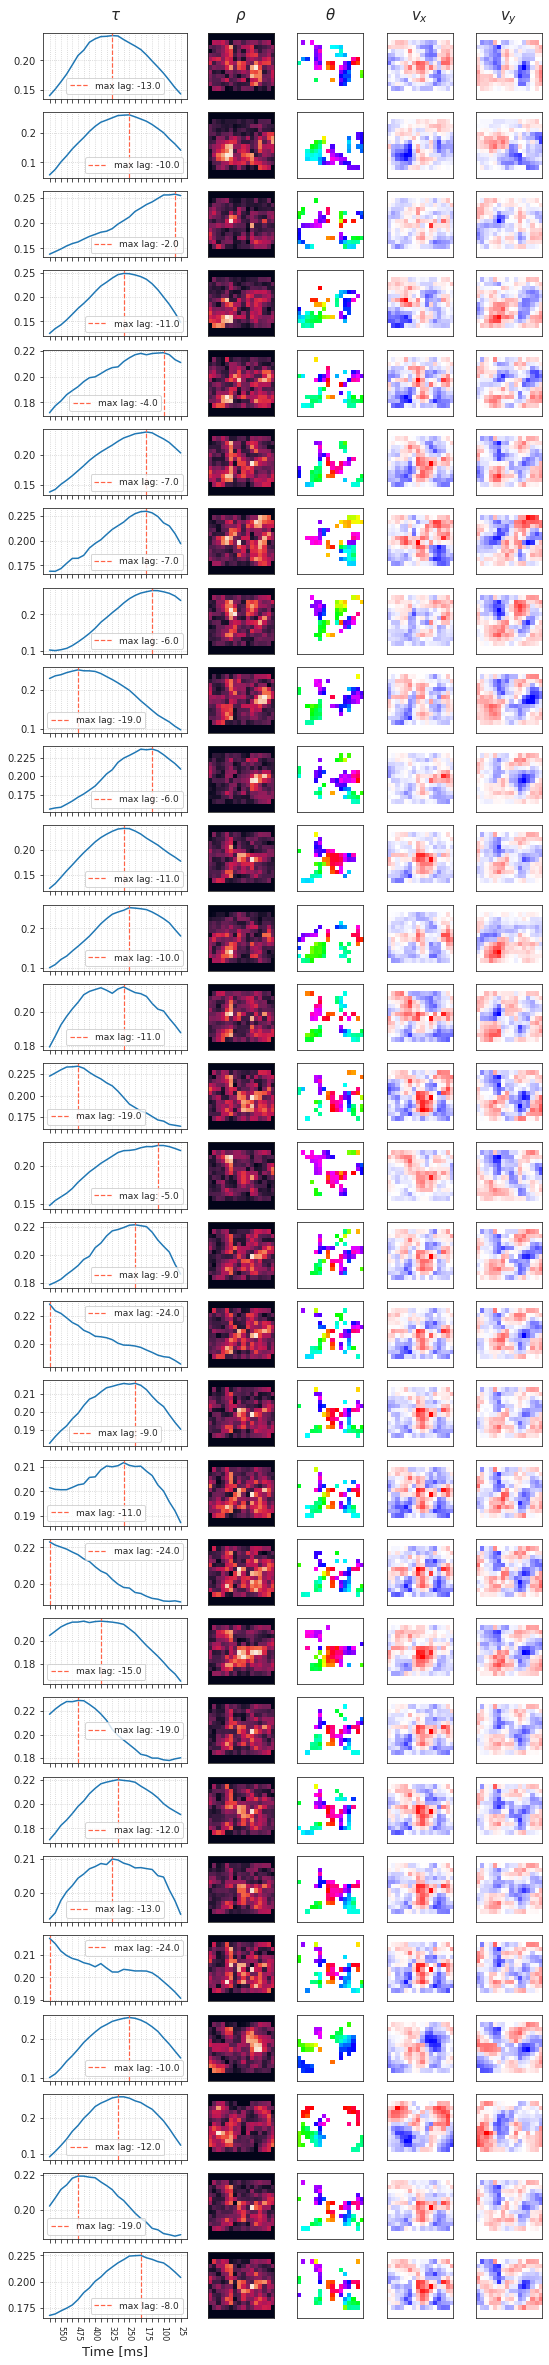

In [65]:
sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()

In [66]:
mat['stim1'].astype(float).shape

(43200, 450)

In [ ]:
seg = range(segments[0], segments[1])
sta = compute_sta(
    lags=lags,
    good=np.where(good_spks[seg])[0],
    stim=stim[seg],
    spks=spks[seg][..., 0],
)
sta.shape

sta = VelField(sta[good_channels[..., 0]], name=mat['expt_name'].item())
_ = sta.show()